In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Preprocessing_68/processed_after_outliers.csv',sep=',', parse_dates=['datetime'],index_col='datetime')

print(df.shape)
print(df.head())

(2049280, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                3.358                  0.418   234.84   
2006-12-16 17:25:00                3.358                  0.436   233.63   
2006-12-16 17:26:00                3.358                  0.498   233.29   
2006-12-16 17:27:00                3.358                  0.502   233.74   
2006-12-16 17:28:00                3.358                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

In [3]:
##Create lag features

#Lag 1 - value from previous minute
df['lag_1'] = df['Global_active_power'].shift(1)

#Lag 60 - value from 1 hour before (60 minutes)
df['lag_60'] = df['Global_active_power'].shift(60)

#Lag 1440 - value from 1 day before (1440 minutes)
df['lag_1440'] = df['Global_active_power'].shift(1440)

In [4]:
##Rolling Mean

#Rolling mean over the last 60 minutes
df['roll_mean_60'] = df['Global_active_power'].rolling(window=60, min_periods=1).mean()

#Rolling standard deviation over the last 60 minutes
df['roll_std_60'] = df['Global_active_power'].rolling(window=60, min_periods=1).std()

In [5]:
import numpy as np

##Time based features

df['hour'] = df.index.hour #hour of the day
df['dayofweek'] = df.index.dayofweek  #day of the week
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int) #weekend flag

# Cyclical encoding for hour of day to captures daily cycle smoothly
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [6]:
#Drop rows with NaNs (from lag/rolling features)
df_ml = df.dropna()

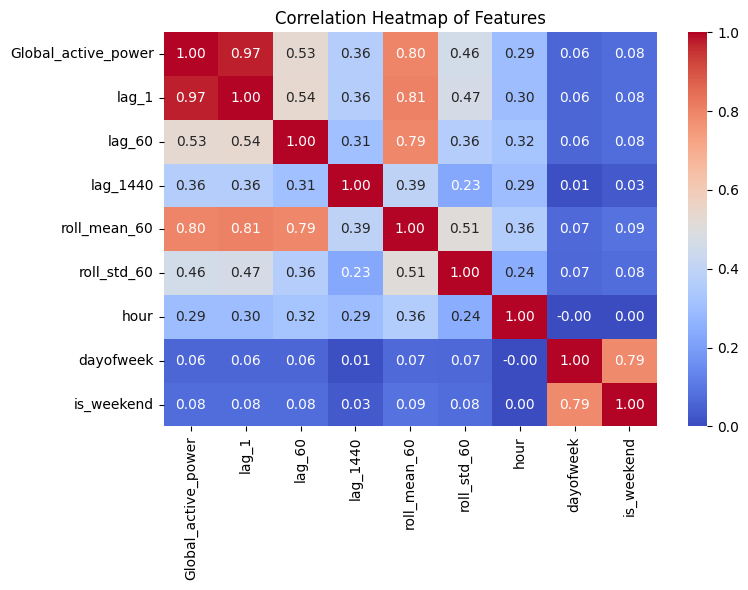

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# only target & engineered features
corr_features = ['Global_active_power','lag_1','lag_60','lag_1440','roll_mean_60','roll_std_60','hour','dayofweek','is_weekend']
corr = df_ml[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Preprocessing_68/eda_visualizations/correlation_heatmap.png',dpi=300, bbox_inches='tight')
plt.show()


In [8]:
##Feature Selection (Random Forest)

from sklearn.ensemble import RandomForestRegressor

#random sample (50,000 rows)
df_sample = df_ml.sample(n=50000, random_state=42)
rf = RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=-1)
feature_cols = ['lag_1','lag_60','lag_1440','roll_mean_60','roll_std_60','hour','dayofweek','is_weekend','hour_sin','hour_cos'] #only engineered columns

X = df_sample[feature_cols]
y = df_sample['Global_active_power']

rf.fit(X, y) #train model

# Get feature importance
feat_imp = pd.DataFrame({'Feature': X.columns,'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

print("Feature Importance Ranking:\n", feat_imp)

Feature Importance Ranking:
         Feature  Importance
0         lag_1    0.954122
3  roll_mean_60    0.010303
4   roll_std_60    0.010050
1        lag_60    0.007614
2      lag_1440    0.007256
8      hour_sin    0.002663
9      hour_cos    0.002661
5          hour    0.002466
6     dayofweek    0.002404
7    is_weekend    0.000460


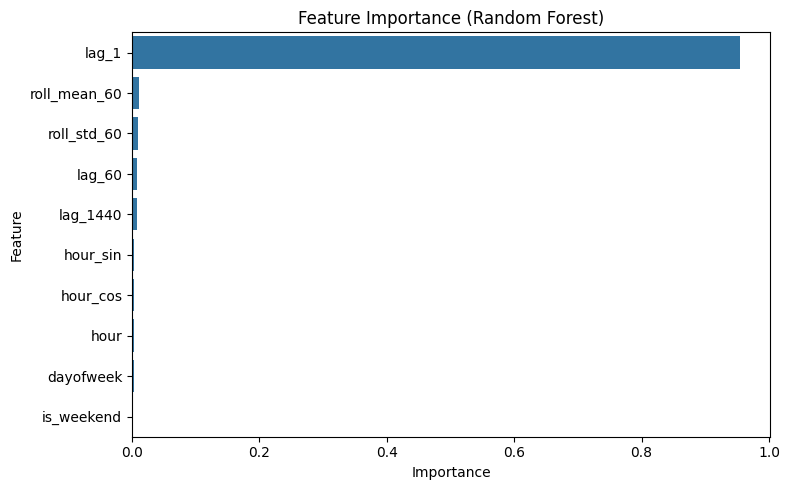

In [9]:
#feature importance plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Preprocessing_68/eda_visualizations/feature_importance.png',dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# Select top 5 features
top_features = feat_imp['Feature'].head(5).tolist()
print("Top selected features:", top_features)
X_selected = df_ml[top_features]

Top selected features: ['lag_1', 'roll_mean_60', 'roll_std_60', 'lag_60', 'lag_1440']


In [14]:
# Save processed dataset after feature engineering

# original features in your dataset (except the target)
original_features = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                     'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# final set = original + top engineered + target
final_features = original_features + top_features + ['Global_active_power']

df_final = df_ml[final_features]

# Save to CSV
df_final.to_csv('/content/drive/MyDrive/Preprocessing_68/processed_selected_features.csv')
print("Saved with columns:", df_final.columns.tolist())

Saved with columns: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'lag_1', 'roll_mean_60', 'roll_std_60', 'lag_60', 'lag_1440', 'Global_active_power']
